# Zero-Shot Learning with Newsgroups Dataset

In this notebook, we implement a zero‑shot classification model for text classification using a subset of the **20 Newsgroups** dataset. Our approach leverages:

- A pre-trained multilingual encoder (DistilBERT) for robust text representation.
- A trainable projection layer that maps text embeddings to a candidate label embedding space.
- Dynamic computation of candidate label embeddings, ensuring that the projection layer receives gradient updates from both text and label pathways.
- A training loop with a learning rate scheduler to adaptively reduce the learning rate when progress stalls.
- Multiple evaluation visualizations including training loss curves, confusion matrices, and t‑SNE embeddings.

This framework enables the model to learn to associate input texts with candidate labels (e.g., "Sports", "Politics", "Sci/Tech", "Technology") even when explicit training examples for each label might be limited.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Data Loading and Preprocessing

We use the scikit‑learn `fetch_20newsgroups` function to load text data from four selected categories:

- `rec.sport.baseball`
- `talk.politics.mideast`
- `sci.space`
- `comp.sys.mac.hardware`

These categories are remapped to our candidate labels:

- **Sports**
- **Politics**
- **Sci/Tech**
- **Technology**

For cleaner text, headers, footers, and quotes are removed. The dataset is then split into training and testing samples. This step provides us with a realistic dataset containing diverse and noisy text, which is essential for building robust zero‑shot classifiers.

In [2]:
# Define the four categories
categories = ['rec.sport.baseball', 'talk.politics.mideast', 'sci.space', 'comp.sys.mac.hardware']
# Load the data (remove headers, footers, and quotes for cleaner text)
data_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
data_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))

train_texts = data_train.data
train_labels = data_train.target  # labels: 0,1,2,3 corresponding to the order in 'categories'
test_texts = data_test.data
test_labels = data_test.target

# Map candidate labels for zero-shot (these should match the order of the loaded categories)
candidate_labels = ["Sports", "Politics", "Sci/Tech", "Technology"]

print(f"Loaded {len(train_texts)} training samples and {len(test_texts)} test samples.")

Loaded 2332 training samples and 1552 test samples.


# Custom Dataset Class

The `CustomTextDataset` class encapsulates data preprocessing. For each sample, it:

1. **Tokenizes** the text using a Hugging Face tokenizer (in our case, the DistilBERT multilingual tokenizer).
2. **Encodes** the text into token IDs and attention masks with a fixed maximum sequence length (here, 256 tokens). Padding and truncation ensure that every input is of uniform length.
3. **Returns** a dictionary containing the processed inputs and the corresponding label.

This abstraction makes it simple to integrate with PyTorch's `DataLoader` for efficient batching and shuffling during training.

In [3]:
class CustomTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['label'] = torch.tensor(label)
        return item

# Load a multilingual tokenizer (using DistilBERT multilingual)
model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create dataset objects and DataLoaders
train_dataset = CustomTextDataset(train_texts, train_labels, tokenizer)
test_dataset = CustomTextDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Zero-Shot Classifier Model Architecture

The `ZeroShotClassifier` model comprises two primary components:

1. **Encoder and Projection:**

   - **Encoder:** A pre-trained DistilBERT model extracts deep contextual embeddings $ E(x) $ for input text $ x $.
   - **Projection Layer:** A linear layer transforms these embeddings into a space where they can be compared directly to candidate label embeddings. Mathematically, this is represented as:
     
     $$
     P(x) = \frac{W \, E(x)}{\|W \, E(x)\|}
     $$
     
     where:
     - $ E(x) $ is the text embedding from the encoder.
     - $ W $ is the weight matrix of the projection layer.
     - $ P(x) $ is the normalized projected embedding.
     - The normalization ensures that embeddings lie on the unit hypersphere, enabling the use of cosine similarity.

2. **Dynamic Candidate Label Embedding:**

   The candidate labels (e.g., "Sports", "Politics") are passed through the same projection pipeline, yielding embeddings $ P(l) $ for each label $ l $. This dynamic computation guarantees that the projection layer's gradients are updated both by the input texts and the candidate labels.

3. **Similarity Computation:**

   The final logits are computed as the cosine similarity (dot product) between the normalized text embeddings and candidate label embeddings:
   
   $$
   \text{logits}(x, l) = \langle P(x), P(l) \rangle
   $$
   
   This formulation directly measures the alignment between text and label representations.

In [4]:
class ZeroShotClassifier(nn.Module):
    def __init__(self, encoder_model_name, candidate_labels, device):
        super(ZeroShotClassifier, self).__init__()
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(encoder_model_name)
        self.encoder = AutoModel.from_pretrained(encoder_model_name).to(device)
        hidden_size = self.encoder.config.hidden_size
        self.projection = nn.Linear(hidden_size, hidden_size).to(device)
        self.candidate_labels = candidate_labels

    def get_label_embeddings(self, labels):
        # Compute candidate label embeddings on-the-fly so that gradients flow
        inputs = self.tokenizer(labels, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        outputs = self.encoder(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # use [CLS] token
        projected = self.projection(cls_embeddings)
        normalized = nn.functional.normalize(projected, p=2, dim=1)
        return normalized

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        projected = self.projection(cls_embeddings)
        normalized = nn.functional.normalize(projected, p=2, dim=1)
        # Dynamically compute candidate label embeddings
        label_embeddings = self.get_label_embeddings(self.candidate_labels)
        logits = torch.matmul(normalized, label_embeddings.T)
        return logits

# Instantiate the model
model = ZeroShotClassifier(model_name, candidate_labels, device)
model.to(device)

ZeroShotClassifier(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1):

# Training Loop and Learning Rate Scheduler

The model is trained using the **cross-entropy loss**:

$$
\mathcal{L} = -\sum_{i} y_i \log(\hat{y}_i)
$$

where:
- $ y_i $ is the true label (one-hot encoded).
- $ \hat{y}_i $ is the predicted probability for class $ i $.

Key components of the training loop:

- **Optimizer:** Adam optimizer with an initial learning rate of $ 2 \times 10^{-5} $.
- **Scheduler:** A `ReduceLROnPlateau` scheduler monitors the training loss. If the loss does not improve for a predefined patience period, the learning rate is reduced by a factor (here, 0.5). This adaptive strategy can help the model escape plateaus and fine-tune its parameters more effectively.

During each epoch, the model processes mini-batches of training data, computes the loss, backpropagates the gradients, and updates the parameters accordingly. The average loss per epoch is recorded and later visualized.

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels_batch = batch["label"].to(device)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    scheduler.step(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 0.9494
Epoch 2/10, Loss: 0.6994
Epoch 3/10, Loss: 0.6627
Epoch 4/10, Loss: 0.6409
Epoch 5/10, Loss: 0.6297
Epoch 6/10, Loss: 0.6206
Epoch 7/10, Loss: 0.6190
Epoch 8/10, Loss: 0.6164
Epoch 9/10, Loss: 0.6168
Epoch 10/10, Loss: 0.6136


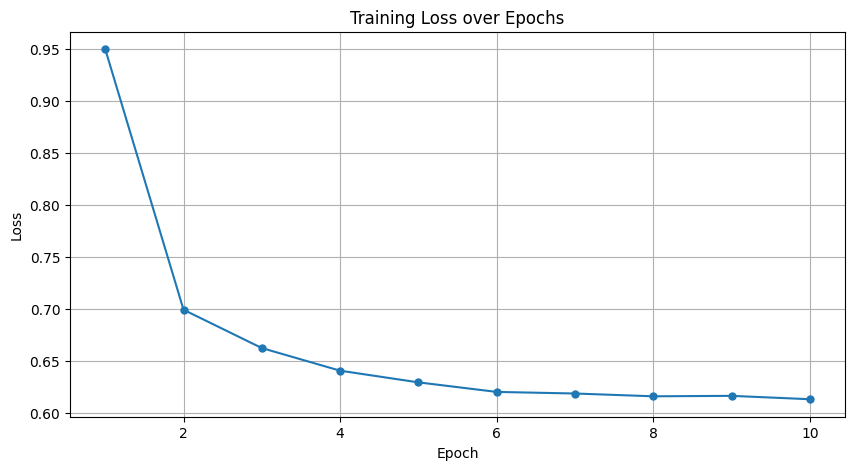

In [6]:
# Plot training loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', markersize=5)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Evaluation Metrics and Visualizations

Once training is complete, we evaluate the model on the test set using multiple metrics:

- **Accuracy:** The fraction of correct predictions.
- **Weighted F1 Score:** Harmonic mean of precision and recall, adjusted for the class distribution.
- **Confusion Matrix:** A heatmap visualization that shows the number of true vs. predicted labels for each class. This helps identify misclassification patterns.

Additionally, we use **t‑SNE** (t-distributed Stochastic Neighbor Embedding) to visualize the high-dimensional embeddings:

- **t‑SNE Overview:** This technique reduces high-dimensional data to two dimensions while preserving local structure. It enables us to visually inspect how test text embeddings align with candidate label embeddings.
- **Interpretation:** Clusters in the t‑SNE plot can indicate groups of texts that are semantically similar and how closely they associate with the candidate label embeddings.

In [7]:
model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels_batch = batch["label"].to(device)

        logits = model(input_ids, attention_mask)
        predicted = torch.argmax(logits, dim=1)

        preds.extend(predicted.cpu().numpy())
        true_labels.extend(labels_batch.cpu().numpy())

accuracy = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

# Use unique labels present for the classification report
unique_labels = np.unique(true_labels)
unique_target_names = [candidate_labels[i] for i in unique_labels]
print("\nClassification Report:\n", classification_report(true_labels, preds, labels=unique_labels, target_names=unique_target_names, zero_division=0))

Test Accuracy: 0.9098
Weighted F1 Score: 0.9099

Classification Report:
               precision    recall  f1-score   support

      Sports       0.87      0.94      0.90       385
    Politics       0.94      0.91      0.92       397
    Sci/Tech       0.90      0.88      0.89       394
  Technology       0.94      0.91      0.93       376

    accuracy                           0.91      1552
   macro avg       0.91      0.91      0.91      1552
weighted avg       0.91      0.91      0.91      1552



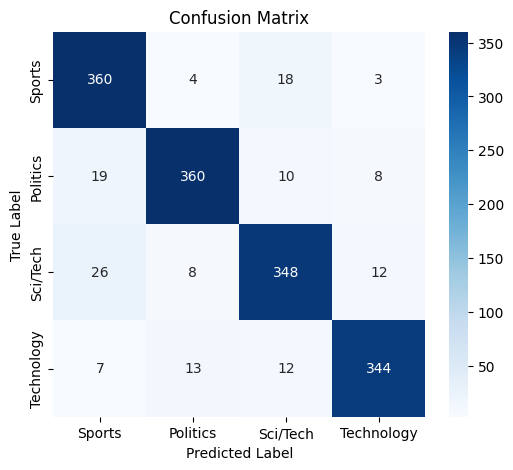

In [8]:
cm = confusion_matrix(true_labels, preds, labels=unique_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=unique_target_names, yticklabels=unique_target_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

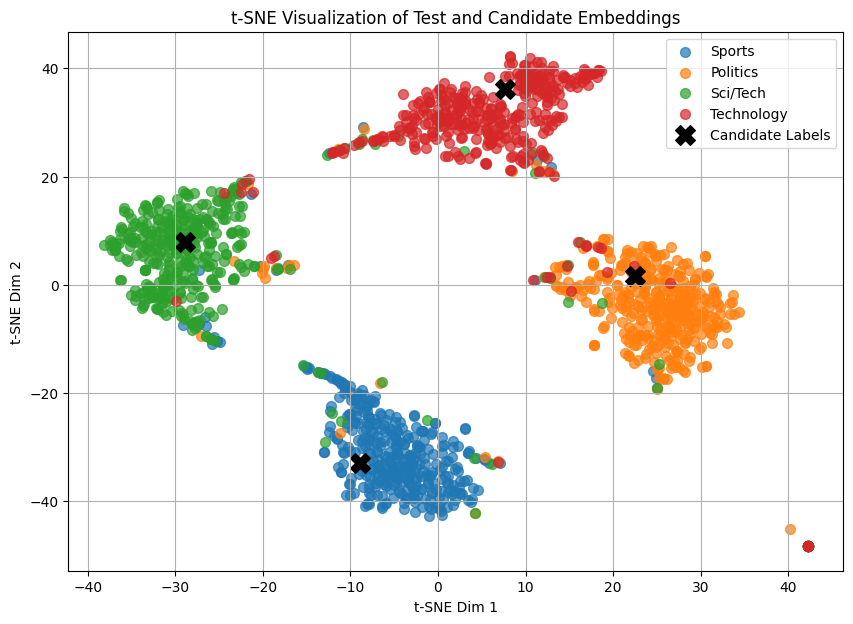

In [9]:
# Compute test set embeddings
all_test_embeddings = []
test_labels_list = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        projected = model.projection(cls_embeddings)
        normalized = nn.functional.normalize(projected, p=2, dim=1)
        all_test_embeddings.append(normalized.cpu().numpy())
        test_labels_list.extend(batch["label"].cpu().numpy())

all_test_embeddings = np.concatenate(all_test_embeddings, axis=0)

# Compute candidate label embeddings
candidate_embeddings = model.get_label_embeddings(candidate_labels).detach().cpu().numpy()

# Combine embeddings for t‑SNE
combined_embeddings = np.concatenate([all_test_embeddings, candidate_embeddings], axis=0)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_embeddings)

# Separate t‑SNE results
tsne_test = tsne_results[:len(all_test_embeddings)]
tsne_candidates = tsne_results[len(all_test_embeddings):]

plt.figure(figsize=(10, 7))
for label in np.unique(test_labels_list):
    indices = [i for i, l in enumerate(test_labels_list) if l == label]
    plt.scatter(tsne_test[indices, 0], tsne_test[indices, 1], label=candidate_labels[label], s=50, alpha=0.7)
plt.scatter(tsne_candidates[:, 0], tsne_candidates[:, 1], marker='X', s=200, c='black', label='Candidate Labels')
plt.title("t-SNE Visualization of Test and Candidate Embeddings")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()
plt.grid(True)
plt.show()